In [1]:
library(dplyr)
library(lubridate)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




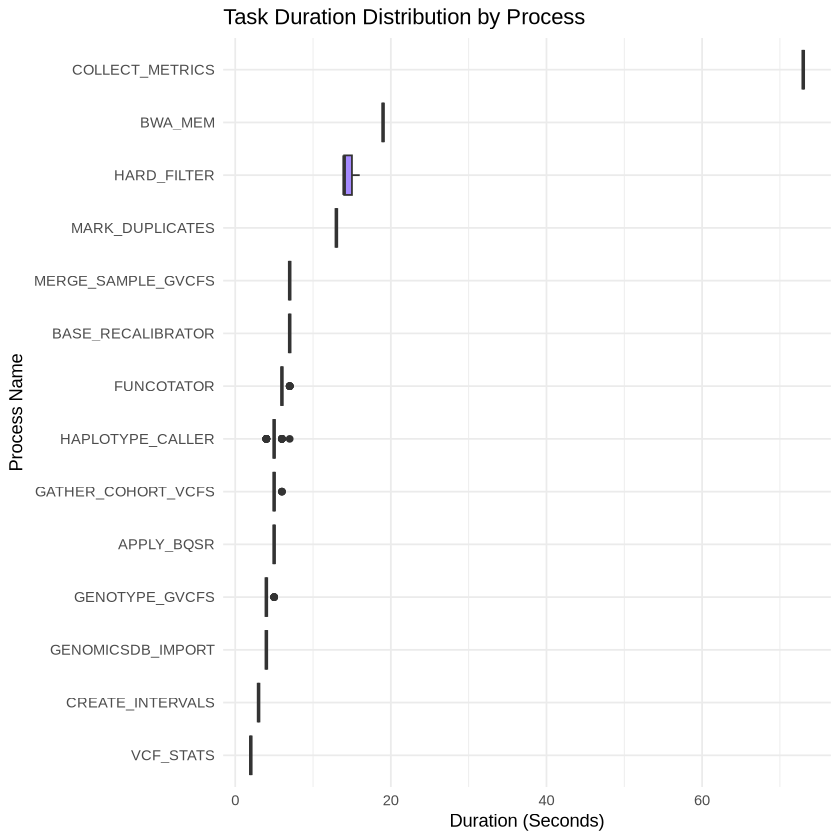

In [2]:
df <- read.csv("nf_final_results.csv")

ggplot(df, aes(x = reorder(process, duration_sec, FUN = median), y = duration_sec, fill = process)) +
  geom_boxplot() +
  coord_flip() +
  theme_minimal() +
  labs(title = "Task Duration Distribution by Process",
       x = "Process Name",
       y = "Duration (Seconds)") +
  theme(legend.position = "none")

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


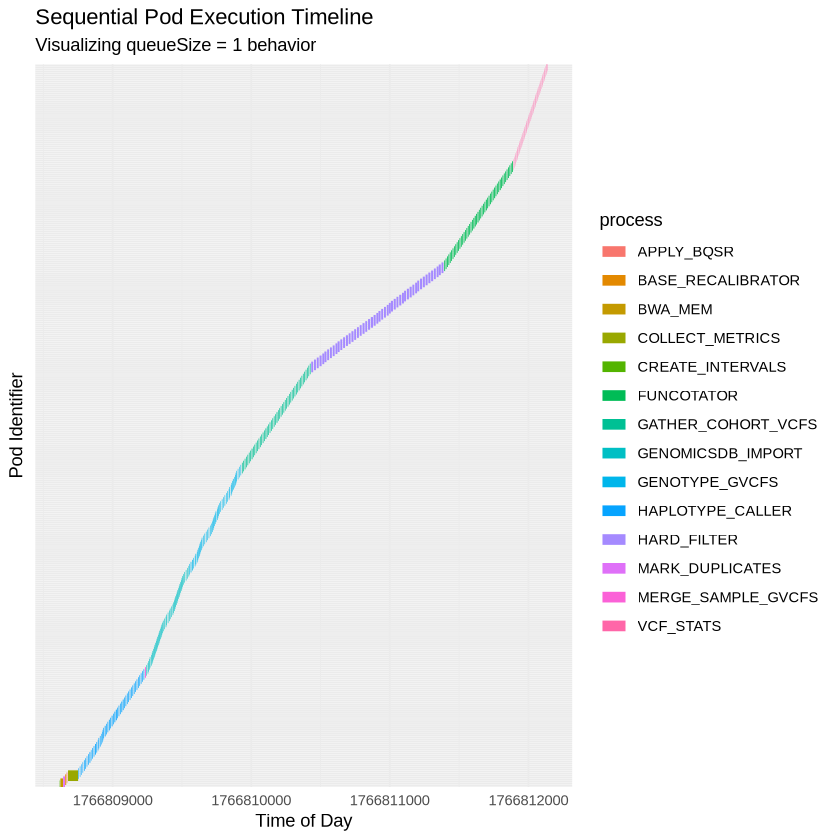

In [3]:
# Ensure times are in POSIXct format
df$start_time <- as.POSIXct(df$start_time, format="%Y-%m-%dT%H:%M:%SZ")
df$end_time <- as.POSIXct(df$end_time, format="%Y-%m-%dT%H:%M:%SZ")

ggplot(df, aes(xmin = start_time, xmax = end_time, y = reorder(pod_name, start_time), color = process)) +
  geom_linerange(size = 3) +
  theme_minimal() +
  labs(title = "Sequential Pod Execution Timeline",
       subtitle = "Visualizing queueSize = 1 behavior",
       x = "Time of Day",
       y = "Pod Identifier") +
  theme(axis.text.y = element_blank()) # Remove pod names if too many

In [4]:
# Assuming df is already loaded and times converted to POSIXct
efficiency_df <- df %>%
  arrange(start_time) %>%
  mutate(
    # Time gap between the end of previous pod and start of current pod
    idle_gap_sec = as.numeric(difftime(start_time, lag(end_time), units="secs"))
  )

total_idle_min <- sum(efficiency_df$idle_gap_sec, na.rm = TRUE) / 60
cat("Total Pipeline Duration:", as.numeric(difftime(max(df$end_time), min(df$start_time), units="mins")), "minutes\n")
cat("Total Idle Time (K8s Overhead):", round(total_idle_min, 2), "minutes\n")

Total Pipeline Duration: 58.7 minutes
Total Idle Time (K8s Overhead): 22.65 minutes


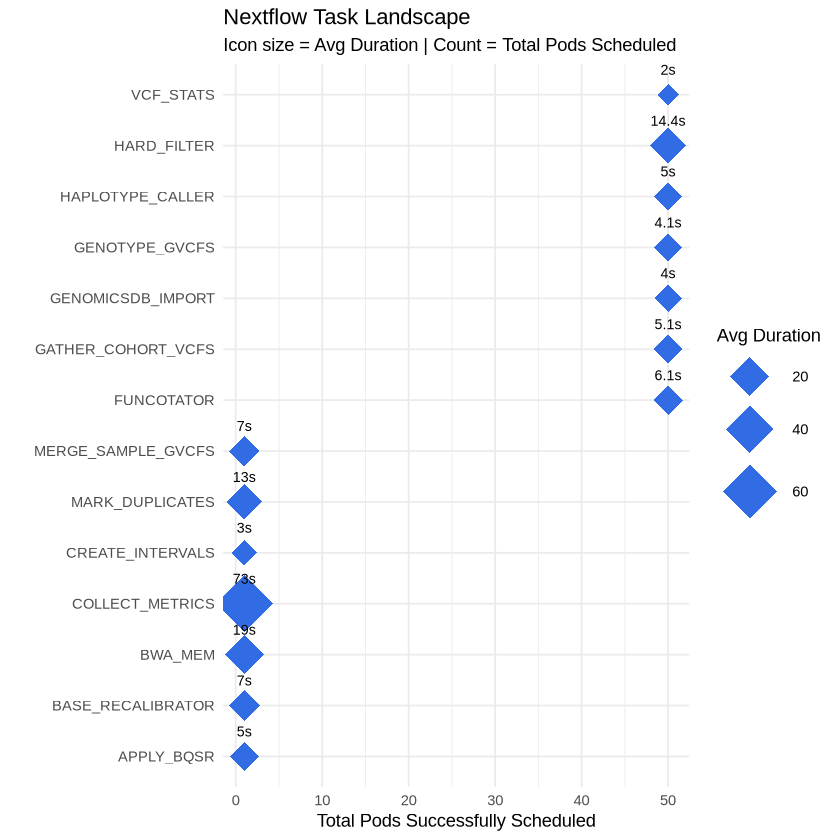

In [23]:
plot_data <- df %>%
  group_by(process) %>%
  summarise(
    pod_count = n(),
    avg_duration = mean(duration_sec)
  )

ggplot(plot_data, aes(x = reorder(process, pod_count), y = pod_count)) +
  # Use hexagon shape with K8s blue color
  geom_point(aes(size = avg_duration), color = "#326CE5", shape = 18, stroke = 1.5) +
  geom_text(aes(label = paste0(round(avg_duration, 1), "s")), 
            vjust = -2, size = 3) +
  scale_size_continuous(range = c(5, 15)) +
  coord_flip() +
  theme_minimal() +
  labs(
    title = "Nextflow Task Landscape",
    subtitle = "Icon size = Avg Duration | Count = Total Pods Scheduled",
    x = "",
    y = "Total Pods Successfully Scheduled",
    size = "Avg Duration"
  )